In [1]:
# !pip install stable-baselines3 gym
# !pip install "shimmy>=2.0"
# !pip install opencv-python
# !pip install seaborn



In [2]:
# Add project root to import path (temporary)
import sys
sys.path.insert(0, r"c:\Users\Acer\Desktop\snake-gym")
import snake_gym

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
import gym
import snake_gym
import random

env = gym.make("snake-v0")
# obs = env.reset()
# done = False

# while not done:
#     action = random.choice([0, 1, 2, 3])
#     obs, reward, done, info = env.step(action)

c:\Users\Acer\Desktop\snake-gym\.venv\lib\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (150, 150)
  logger.warn(


In [4]:
import random
import numpy as np
import time
import psutil
import pickle
import cv2
import pygame
from collections import deque
from snake_gym.envs.snake import SnakeGame
from snake_gym.envs.modules import GRIDSIZE
import torch
import torch.nn as nn
import torch.optim as optim
import os

# =============================================================================
# METRICS LOGGER
# =============================================================================
class MetricsLogger:
    """Comprehensive metrics tracking for RL training"""
    
    def __init__(self, agent_name, seed, record_gameplay=True, record_frequency=500):
        self.agent_name = agent_name
        self.seed = seed
        self.start_time = time.time()
        self.record_gameplay = record_gameplay
        self.record_frequency = record_frequency
        self.recorded_episodes = []
        self.best_episode_score = 0
        self.best_episode_number = 0
        self.episode_rewards = []
        self.episode_scores = []
        self.episode_lengths = []
        self.episode_times = []
        self.reward_variance_per_block = []
        self.score_variance_per_block = []
        self.epsilon_history = []
        self.action_counts = {0:0,1:0,2:0,3:0}
        self.action_history_per_block = []
        self.cpu_usage = []
        self.memory_usage = []
        self.moving_avg_reward = []
        self.moving_avg_score = []
        self.episodes_to_threshold = {}
    
    def should_record_episode(self, episode_num):
        if not self.record_gameplay:
            return False
        if episode_num % self.record_frequency == 0:
            return True
        return False
    
    def is_best_episode(self, score):
        return score > self.best_episode_score
    
    def update_best_episode(self, episode_num, score):
        if score > self.best_episode_score:
            self.best_episode_score = score
            self.best_episode_number = episode_num
            return True
        return False
    
    def log_episode(self, reward, score, length, epsilon, episode_time, actions_taken):
        self.episode_rewards.append(reward)
        self.episode_scores.append(score)
        self.episode_lengths.append(length)
        self.episode_times.append(episode_time)
        self.epsilon_history.append(epsilon)
        for action in actions_taken:
            self.action_counts[action] += 1
        window = 100
        if len(self.episode_rewards) >= window:
            self.moving_avg_reward.append(np.mean(self.episode_rewards[-window:]))
            self.moving_avg_score.append(np.mean(self.episode_scores[-window:]))
        else:
            self.moving_avg_reward.append(np.mean(self.episode_rewards))
            self.moving_avg_score.append(np.mean(self.episode_scores))
        self.cpu_usage.append(psutil.cpu_percent(interval=0.1))
        self.memory_usage.append(psutil.virtual_memory().percent)
    
    def log_block_statistics(self, block_size=1000):
        if len(self.episode_rewards) >= block_size:
            recent_rewards = self.episode_rewards[-block_size:]
            recent_scores = self.episode_scores[-block_size:]
            self.reward_variance_per_block.append(np.var(recent_rewards))
            self.score_variance_per_block.append(np.var(recent_scores))
            total_actions = sum(self.action_counts.values())
            if total_actions > 0:
                action_dist = {k: v/total_actions for k, v in self.action_counts.items()}
                self.action_history_per_block.append(action_dist)
    
    def check_convergence_threshold(self, threshold_percent=0.8):
        if len(self.moving_avg_score) < 100:
            return
        max_score = max(self.moving_avg_score)
        threshold = threshold_percent * max_score
        threshold_name = f"{int(threshold_percent*100)}%_max"
        if threshold_name not in self.episodes_to_threshold:
            for i, score in enumerate(self.moving_avg_score):
                if score >= threshold:
                    self.episodes_to_threshold[threshold_name] = i + 1
                    print(f"  ✓ Reached {threshold_name} performance at episode {i+1}")
                    break
    
    def get_training_duration(self):
        if self.start_time is not None and self.end_time is not None:
            return self.end_time - self.start_time
        elif self.start_time is not None:
            # fallback if end_time not yet set
            return time.time() - self.start_time
        else:
            return 0

    def get_avg_episode_time(self):
        return np.mean(self.episode_times) if self.episode_times else 0
    
    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.__dict__, f)
        print(f"✅ Metrics saved to {filename}")

# =============================================================================
# DQN NETWORK AND REPLAY BUFFER
# =============================================================================
class DQN(nn.Module):
    def __init__(self, input_dim=12, output_dim=4):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size=64):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), actions, rewards, np.array(next_states), dones
    def __len__(self):
        return len(self.buffer)

# =============================================================================
# STATE REPRESENTATION
# =============================================================================
def get_state(env):
    head_x, head_y = env.snake.get_head_position()
    apple_x, apple_y = env.apple.position
    direction = env.snake.direction
    def is_danger(dx, dy):
        new_x = head_x + dx * GRIDSIZE
        new_y = head_y + dy * GRIDSIZE
        if new_x < 0 or new_x >= 150 or new_y < 0 or new_y >= 150:
            return 1
        if (new_x, new_y) in env.snake.positions[:-1]:
            return 1
        return 0
    danger_up = is_danger(0, -GRIDSIZE)
    danger_down = is_danger(0, GRIDSIZE)
    danger_left = is_danger(-GRIDSIZE, 0)
    danger_right = is_danger(GRIDSIZE, 0)
    apple_up = int(apple_y < head_y)
    apple_down = int(apple_y > head_y)
    apple_left = int(apple_x < head_x)
    apple_right = int(apple_x > head_x)
    dir_up = int(direction == (0, -1))
    dir_down = int(direction == (0, 1))
    dir_left = int(direction == (-1, 0))
    dir_right = int(direction == (1, 0))
    return (danger_up, danger_down, danger_left, danger_right,
            apple_up, apple_down, apple_left, apple_right,
            dir_up, dir_down, dir_left, dir_right)

# =============================================================================
# VIDEO RECORDING
# =============================================================================
def add_info_overlay(frame, episode, steps, score, agent_name, seed):
    overlay = np.zeros((200, 150, 3), dtype=np.uint8)
    overlay[0:150, :] = frame
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.35
    color = (255,255,255)
    thickness = 1
    text_lines = [
        f"Agent: {agent_name}",
        f"Seed: {seed}",
        f"Episode: {episode}",
        f"Step: {steps}",
        f"Score: {score}"
    ]
    y_offset = 160
    for i, text in enumerate(text_lines):
        cv2.putText(overlay, text, (5, y_offset + i*10), font, font_scale, color, thickness, cv2.LINE_AA)
    return overlay

def record_episode(env, state_func, policy_net, epsilon, episode_num, agent_name, seed, video_path, max_steps=1000):
    # Capture first frame to determine video size
    state = env.reset()
    state = state_func(env)
    first_frame = pygame.surfarray.array3d(env.screen)
    first_frame = np.transpose(first_frame, (1,0,2))
    first_frame = cv2.cvtColor(first_frame, cv2.COLOR_RGB2BGR)

    overlay_height = 50
    height, width, _ = first_frame.shape
    frame_height = height + overlay_height

    # Initialize VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = 15
    video_writer = cv2.VideoWriter(video_path, fourcc, fps, (width, frame_height))

    state = env.reset()
    state = state_func(env)
    done = False
    steps = 0
    total_reward = 0
    actions_taken = []

    while not done and steps < max_steps:
        if random.random() < min(epsilon, 0.1):
            action = random.randint(0,3)
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(state).float().unsqueeze(0)
                action = policy_net(state_tensor).argmax().item()

        actions_taken.append(action)
        _, reward, done, _ = env.step(action)
        state = state_func(env)
        total_reward += reward

        # Capture frame
        frame = pygame.surfarray.array3d(env.screen)
        frame = np.transpose(frame, (1,0,2))
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # Add overlay
        overlay = np.zeros((frame_height, width, 3), dtype=np.uint8)
        overlay[0:height,:,:] = frame
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.35
        color = (255,255,255)
        thickness = 1
        y_offset = height + 15
        text_lines = [
            f"Agent: {agent_name}",
            f"Seed: {seed}",
            f"Episode: {episode_num}",
            f"Step: {steps}",
            f"Score: {env.snake.length-1}"
        ]
        for i, text in enumerate(text_lines):
            cv2.putText(overlay, text, (5, y_offset + i*12), font, font_scale, color, thickness, cv2.LINE_AA)

        overlay = np.ascontiguousarray(overlay, dtype=np.uint8)
        video_writer.write(overlay)
        steps += 1

    video_writer.release()
    score = env.snake.length-1
    return score, total_reward, steps, actions_taken

# =============================================================================
# DQN TRAINING
# =============================================================================
def train_dqn(seed=42, num_episodes=2000, agent_name="DQN", record_gameplay=True, record_frequency=500):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    env = SnakeGame()
    recordings_dir = f"recordings_{agent_name.lower().replace(' ','_')}_seed{seed}"
    os.makedirs(recordings_dir, exist_ok=True)
    
    input_dim = 12
    output_dim = 4
    policy_net = DQN(input_dim, output_dim)
    target_net = DQN(input_dim, output_dim)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    replay_buffer = ReplayBuffer(10000)
    
    batch_size = 64
    gamma = 0.95
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.995
    target_update = 10
    
    metrics = MetricsLogger(agent_name, seed, record_gameplay, record_frequency)
    metrics.start_time = time.time()  # ✅ Start timing training
    
    for episode in range(num_episodes):
        episode_start = time.time()
        should_record = metrics.should_record_episode(episode+1)
        
        if should_record:
            video_path = f"{recordings_dir}/episode_{episode+1:05d}.mp4"
            score, total_reward, steps, actions_taken = record_episode(env, get_state, policy_net, epsilon, episode+1, agent_name, seed, video_path)
            metrics.recorded_episodes.append(episode+1)
        else:
            state = get_state(env)
            done = False
            total_reward = 0
            steps = 0
            actions_taken = []
            while not done and steps < 1000:
                
                if random.random() < epsilon:
                    action = random.randint(0,3)
                else:
                    with torch.no_grad():
                        state_tensor = torch.tensor(state).float().unsqueeze(0)
                        action = policy_net(state_tensor).argmax().item()
                        
                actions_taken.append(action)
                _, reward, done, _ = env.step(action)
                next_state = get_state(env)
                
                replay_buffer.push(state, action, reward, next_state, done)
                if len(replay_buffer) >= batch_size:
                    s, a, r, s_next, d = replay_buffer.sample(batch_size)
                    
                    s_tensor = torch.tensor(s).float()
                    a_tensor = torch.tensor(a).long().unsqueeze(1)
                    r_tensor = torch.tensor(r).float().unsqueeze(1)
                    s_next_tensor = torch.tensor(s_next).float()
                    d_tensor = torch.tensor(d).float().unsqueeze(1)
                    
                    q_values = policy_net(s_tensor).gather(1, a_tensor)
                    next_q_values = target_net(s_next_tensor).max(1)[0].unsqueeze(1)
                    target = r_tensor + gamma * next_q_values * (1 - d_tensor)
                    loss = criterion(q_values, target)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                state = next_state
                total_reward += reward
                steps +=1
            score = env.snake.length-1
        
        if metrics.update_best_episode(episode+1, score):
            print(f"  🏆 New best score: {score} at episode {episode+1}")
        
        epsilon = max(epsilon_min, epsilon*epsilon_decay)
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        metrics.log_episode(total_reward, score, steps, epsilon, time.time()-episode_start, actions_taken)
        
        if (episode+1) % 100 ==0:
            metrics.check_convergence_threshold(0.5)
            metrics.check_convergence_threshold(0.8)
            metrics.check_convergence_threshold(0.9)
            
            metrics.log_block_statistics(block_size=100)
            print(f"  → Logged block statistics for last 100 episodes.")
            
            # Compute additional metrics for printing
            avg_score = np.mean(metrics.episode_scores[-100:])
            max_score = max(metrics.episode_scores[-100:])
            avg_reward = np.mean(metrics.episode_rewards[-100:])
            avg_reward_per_step = np.mean([r/l if l>0 else 0 for r,l in zip(metrics.episode_rewards[-100:], metrics.episode_lengths[-100:])])
            current_epsilon = metrics.epsilon_history[-1] if metrics.epsilon_history else 0
            
            
            
            print(f"Episode {episode+1:5d} | "
                f"Avg Score: {avg_score:5.2f} | "
                f"Max Score: {max_score:3d} | "
                f"Avg Reward: {avg_reward:7.2f} | "
                f"Avg Reward/Step: {avg_reward_per_step:.3f} | "
                f"ε: {current_epsilon:.3f}")

    metrics.end_time = time.time()  # ✅ End timing training
    
    if record_gameplay and metrics.best_episode_number>0:
        best_video_path = f"{recordings_dir}/BEST_episode_{metrics.best_episode_number:05d}_score_{metrics.best_episode_score}.mp4"
        record_episode(env, get_state, policy_net, 0.0, metrics.best_episode_number, agent_name, seed, best_video_path)
    
    # 🎬 Record final gameplay after full training (fully greedy policy)
    print("\n🎬 Recording final gameplay with trained DQN agent...")
    final_video_path = f"{recordings_dir}/FINAL_gameplay_seed{seed}.mp4"
    env = SnakeGame()
    record_episode(
        env, get_state, policy_net,
        epsilon=0.0,                      # no exploration
        episode_num=num_episodes,         # tag as final episode
        agent_name="DQN-Final",
        seed=seed,
        video_path=final_video_path
    )
    print(f"✅ Final gameplay recording complete! Saved to {final_video_path}")
    
    torch.save(policy_net.state_dict(), f"dqn_policy_net_seed{seed}.pth")
    metrics.save(f"metrics_{agent_name.lower().replace(' ','_')}_seed{seed}.pkl")
    
    return policy_net, metrics

# =============================================================================
# MAIN EXECUTION
# =============================================================================
if __name__ == "__main__":
    seeds = [42, 123, 456]
    all_metrics = []
    for seed in seeds:
        policy_net, metrics = train_dqn(seed=seed, num_episodes=2000, agent_name="DQN", record_gameplay=True, record_frequency=500)
        all_metrics.append(metrics)
        time.sleep(2)
    
    print("\n🎉 All DQN training runs complete!")


  🏆 New best score: 1 at episode 21
  🏆 New best score: 2 at episode 45
  🏆 New best score: 4 at episode 75
  ✓ Reached 50%_max performance at episode 61
  ✓ Reached 80%_max performance at episode 75
  ✓ Reached 90%_max performance at episode 81
  → Logged block statistics for last 100 episodes.
Episode   100 | Avg Score:  0.28 | Max Score:   4 | Avg Reward:   -1.85 | Avg Reward/Step: -0.067 | ε: 0.606
  → Logged block statistics for last 100 episodes.
Episode   200 | Avg Score:  0.68 | Max Score:   4 | Avg Reward:    4.19 | Avg Reward/Step: 0.111 | ε: 0.367
  🏆 New best score: 6 at episode 247
  → Logged block statistics for last 100 episodes.
Episode   300 | Avg Score:  1.02 | Max Score:   6 | Avg Reward:    9.01 | Avg Reward/Step: 0.233 | ε: 0.222
  🏆 New best score: 7 at episode 373
  → Logged block statistics for last 100 episodes.
Episode   400 | Avg Score:  0.92 | Max Score:   7 | Avg Reward:   13.81 | Avg Reward/Step: 0.329 | ε: 0.135
  🏆 New best score: 11 at episode 407
  🏆 N

In [5]:
import cv2
import numpy as np
from pathlib import Path

# =========================
# Safe text overlay helper
# =========================
def safe_put_text(img, text, pos, font_scale=0.4, color=(255,255,255), thickness=1):
    """
    Safely put text on a frame (ensures contiguous array and correct type)
    """
    img = np.ascontiguousarray(img, dtype=np.uint8)
    cv2.putText(img, text, pos, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness, cv2.LINE_AA)
    return img

# =========================
# Training progression video
# =========================
def create_training_progression_video(recordings_dir, output_path='training_progression.mp4'):
    """
    Create a compilation showing DQN training progression
    """
    video_files = sorted(Path(recordings_dir).glob("episode_*.mp4"))
    
    if not video_files:
        print(f"❌ No videos found in {recordings_dir}")
        return
    
    print(f"Found {len(video_files)} recorded episodes")
    print(f"Creating progression video: {output_path}")
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = 15
    
    first_video = cv2.VideoCapture(str(video_files[0]))
    width = int(first_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(first_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    first_video.release()
    
    output_video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    for video_file in video_files:
        print(f"  Processing {video_file.name}...")
        cap = cv2.VideoCapture(str(video_file))
        
        # Title frame
        title_frame = np.zeros((height, width, 3), dtype=np.uint8)
        title_frame = np.ascontiguousarray(title_frame, dtype=np.uint8)
        text = f"Episode {video_file.stem.split('_')[1]}"
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)[0]
        text_x = (width - text_size[0]) // 2
        text_y = (height + text_size[1]) // 2
        title_frame = safe_put_text(title_frame, text, (text_x, text_y), font_scale=0.8, thickness=2)
        
        for _ in range(fps):
            output_video.write(title_frame)
        
        # Write video frames
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = np.ascontiguousarray(frame, dtype=np.uint8)
            output_video.write(frame)
        cap.release()
        
        # Black separator
        black_frame = np.zeros((height, width, 3), dtype=np.uint8)
        black_frame = np.ascontiguousarray(black_frame, dtype=np.uint8)
        for _ in range(fps // 2):
            output_video.write(black_frame)
    
    output_video.release()
    print(f"✅ Compilation video saved: {output_path}")

# =========================
# Best episodes compilation
# =========================
def create_best_episodes_compilation(seed_list=[42, 123, 456], agent_name="DQN"):
    """
    Create compilation of best episodes from all DQN seeds
    """
    output_path = f'best_episodes_{agent_name.lower()}.mp4'
    print(f"Creating best episodes compilation for {agent_name}...")
    
    best_videos = []
    for seed in seed_list:
        recordings_dir = f"recordings_{agent_name.lower()}_seed{seed}"
        best_video = list(Path(recordings_dir).glob("BEST_*.mp4"))
        if best_video:
            best_videos.extend(best_video)
    
    if not best_videos:
        print("❌ No best episode videos found")
        return
    
    cap = cv2.VideoCapture(str(best_videos[0]))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    cap.release()
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    for video_file in best_videos:
        print(f"  Adding {video_file.name}...")
        
        # Title frame
        title_frame = np.zeros((height, width, 3), dtype=np.uint8)
        title_frame = np.ascontiguousarray(title_frame, dtype=np.uint8)
        title_text = video_file.stem.replace('_', ' ').title()
        title_frame = safe_put_text(title_frame, title_text, (10, height//2), font_scale=0.4, thickness=1)
        
        for _ in range(fps):
            output_video.write(title_frame)
        
        # Video frames
        cap = cv2.VideoCapture(str(video_file))
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = np.ascontiguousarray(frame, dtype=np.uint8)
            output_video.write(frame)
        cap.release()
        
        # Black separator
        black_frame = np.zeros((height, width, 3), dtype=np.uint8)
        black_frame = np.ascontiguousarray(black_frame, dtype=np.uint8)
        for _ in range(fps):
            output_video.write(black_frame)
    
    output_video.release()
    print(f"✅ Best episodes compilation saved: {output_path}")

# =========================
# MAIN EXECUTION
# =========================
if __name__ == "__main__":
    print("\n" + "="*80)
    print("DQN VIDEO COMPILATION CREATOR")
    print("="*80 + "\n")
    
    seeds = [42, 123, 456]
    
    # Progression videos
    for seed in seeds:
        recordings_dir = f"recordings_dqn_seed{seed}"
        if Path(recordings_dir).exists():
            create_training_progression_video(
                recordings_dir,
                f'progression_dqn_seed{seed}.mp4'
            )
    
    # Best episodes compilation
    create_best_episodes_compilation(seeds, "DQN")
    
    print("\n🎉 All DQN compilation videos created!")



DQN VIDEO COMPILATION CREATOR

Found 8 recorded episodes
Creating progression video: progression_dqn_seed42.mp4
  Processing episode_00200.mp4...
  Processing episode_00400.mp4...
  Processing episode_00500.mp4...
  Processing episode_00600.mp4...
  Processing episode_00800.mp4...
  Processing episode_01000.mp4...
  Processing episode_01500.mp4...
  Processing episode_02000.mp4...
✅ Compilation video saved: progression_dqn_seed42.mp4
Found 8 recorded episodes
Creating progression video: progression_dqn_seed123.mp4
  Processing episode_00200.mp4...
  Processing episode_00400.mp4...
  Processing episode_00500.mp4...
  Processing episode_00600.mp4...
  Processing episode_00800.mp4...
  Processing episode_01000.mp4...
  Processing episode_01500.mp4...
  Processing episode_02000.mp4...
✅ Compilation video saved: progression_dqn_seed123.mp4
Found 8 recorded episodes
Creating progression video: progression_dqn_seed456.mp4
  Processing episode_00200.mp4...
  Processing episode_00400.mp4...
  

METRICS


COMPREHENSIVE METRICS VISUALIZATION (DQN)

Loading DQN metrics files...
✅ Loaded 3 DQN metric files

Generating visualizations...

✅ Saved: 1_sample_efficiency_dqn.png
✅ Saved: 2_exploration_stability_dqn.png


AttributeError: 'MetricsLogger' object has no attribute 'get_training_duration'

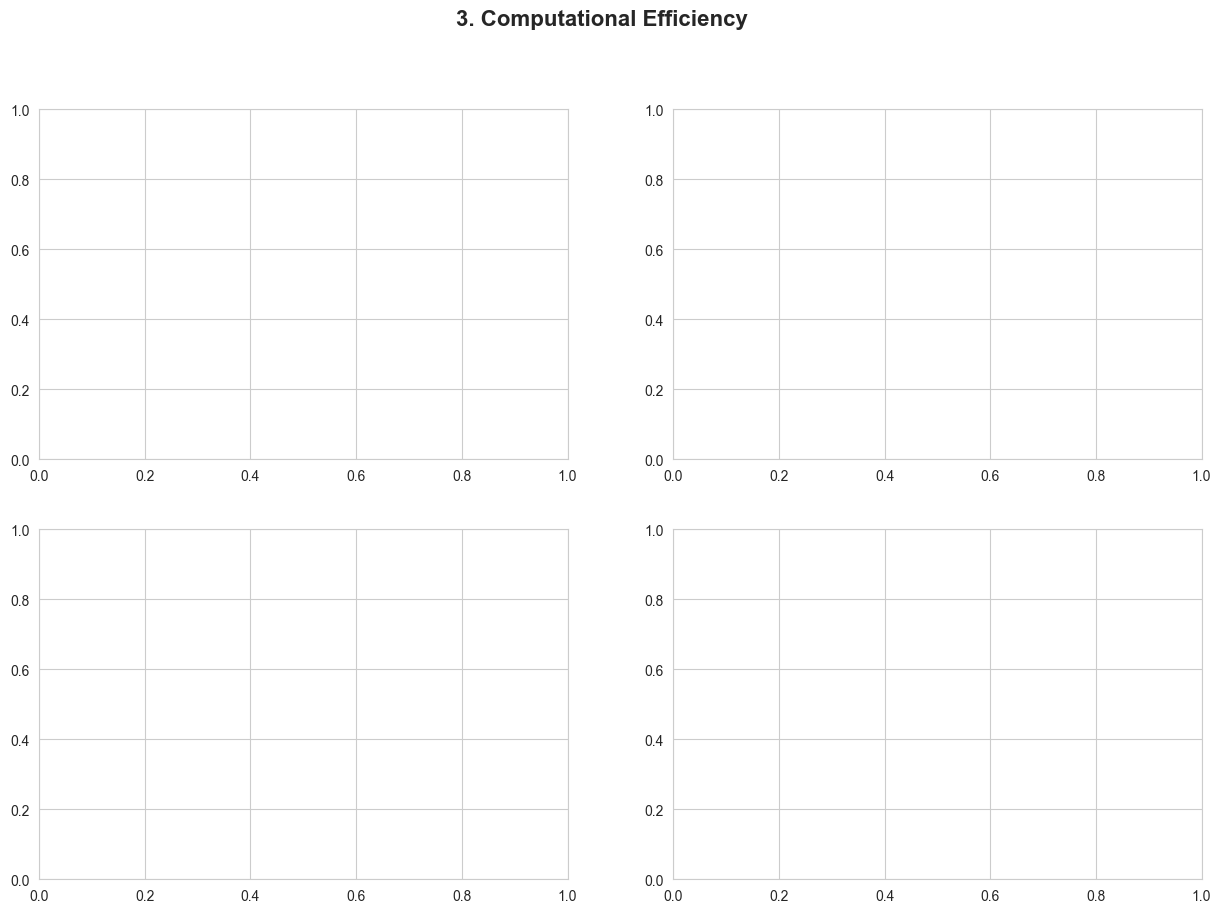

In [12]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

def load_metrics(pattern="metrics_dqn_seed*.pkl"):
    """Load all metrics files matching pattern"""
    from pathlib import Path

    class MetricsLogger:
        """Dummy reconstruction class for DQN metrics"""
        def __init__(self, agent_name, seed):
            self.agent_name = agent_name
            self.seed = seed

    metrics_list = []
    for file in Path('.').glob(pattern):
        with open(file, 'rb') as f:
            metrics = pickle.load(f)
            # Reconstruct MetricsLogger object
            m = MetricsLogger(metrics.get('agent_name', 'DQN'), metrics.get('seed', 0))
            m.__dict__.update(metrics)
            metrics_list.append(m)
    return metrics_list


def plot_sample_efficiency(metrics_list, save_path='1_sample_efficiency_dqn.png'):
    """Sample Efficiency Analysis"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('1. Sample Efficiency Analysis', fontsize=16, fontweight='bold')
    
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    # Plot 1: Reward vs Episodes
    ax = axes[0, 0]
    for i, m in enumerate(metrics_list):
        episodes = range(1, len(m.moving_avg_reward) + 1)
        ax.plot(episodes, m.moving_avg_reward, label=f'Seed {m.seed}', alpha=0.7, color=colors[i % len(colors)])
    ax.set_xlabel('Episode')
    ax.set_ylabel('Moving Avg Reward (window=100)')
    ax.set_title('Learning Curves Across Seeds')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Score vs Episodes
    ax = axes[0, 1]
    for i, m in enumerate(metrics_list):
        episodes = range(1, len(m.moving_avg_score) + 1)
        ax.plot(episodes, m.moving_avg_score, label=f'Seed {m.seed}', alpha=0.7, color=colors[i % len(colors)])
    ax.set_xlabel('Episode')
    ax.set_ylabel('Moving Avg Score (window=100)')
    ax.set_title('Score Progression Across Seeds')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Episodes to Convergence
    ax = axes[1, 0]
    thresholds = ['50%_max', '80%_max', '90%_max']
    threshold_data = {t: [] for t in thresholds}
    for m in metrics_list:
        for t in thresholds:
            value = m.episodes_to_threshold.get(t, np.nan)
            threshold_data[t].append(value)
    x_pos = np.arange(len(thresholds))
    means = [np.nanmean(threshold_data[t]) for t in thresholds]
    stds = [np.nanstd(threshold_data[t]) for t in thresholds]
    ax.bar(x_pos, means, yerr=stds, capsize=5, color='#2E86AB', alpha=0.7)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(thresholds)
    ax.set_ylabel('Episodes Required')
    ax.set_title('Sample Efficiency: Episodes to Reach Performance Thresholds')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Cumulative max score
    ax = axes[1, 1]
    for i, m in enumerate(metrics_list):
        cumulative_max = np.maximum.accumulate(m.episode_scores)
        episodes = range(1, len(cumulative_max) + 1)
        ax.plot(episodes, cumulative_max, label=f'Seed {m.seed}', alpha=0.7, color=colors[i % len(colors)])
    ax.set_xlabel('Episode')
    ax.set_ylabel('Cumulative Max Score')
    ax.set_title('Best Performance Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {save_path}")
    plt.close()


def plot_exploration_stability(metrics_list, save_path='2_exploration_stability_dqn.png'):
    """Exploration Stability"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('2. Exploration & Behavioral Stability', fontsize=16, fontweight='bold')
    
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    # Plot 1: Epsilon decay with reward overlay
    ax = axes[0, 0]
    ax2 = ax.twinx()
    for i, m in enumerate(metrics_list):
        episodes = range(1, len(m.epsilon_history) + 1)
        ax.plot(episodes, m.epsilon_history, label=f'ε (Seed {m.seed})', alpha=0.5, linestyle='--', color=colors[i % len(colors)])
        ax2.plot(episodes, m.moving_avg_reward, label=f'Reward (Seed {m.seed})', alpha=0.7, color=colors[i % len(colors)])
    ax.set_xlabel('Episode')
    ax.set_ylabel('Epsilon (Exploration Rate)')
    ax2.set_ylabel('Moving Avg Reward')
    ax.set_title('Exploration Decay vs Learning Performance')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Reward variance per block
    ax = axes[0, 1]
    for i, m in enumerate(metrics_list):
        blocks = range(1, len(m.reward_variance_per_block) + 1)
        block_episodes = [b * 1000 for b in blocks]
        ax.plot(block_episodes, m.reward_variance_per_block, label=f'Seed {m.seed}', marker='o', alpha=0.7, color=colors[i % len(colors)])
    ax.set_xlabel('Episode (×1000)')
    ax.set_ylabel('Reward Variance')
    ax.set_title('Learning Stability: Reward Variance per 1000 Episodes')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Score variance per block
    ax = axes[1, 0]
    for i, m in enumerate(metrics_list):
        blocks = range(1, len(m.score_variance_per_block) + 1)
        block_episodes = [b * 1000 for b in blocks]
        ax.plot(block_episodes, m.score_variance_per_block, label=f'Seed {m.seed}', marker='o', alpha=0.7, color=colors[i % len(colors)])
    ax.set_xlabel('Episode (×1000)')
    ax.set_ylabel('Score Variance')
    ax.set_title('Performance Stability: Score Variance per 1000 Episodes')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Action distribution (last seed only)
    ax = axes[1, 1]
    m = metrics_list[-1]
    action_names = ['UP (0)', 'DOWN (1)', 'LEFT (2)', 'RIGHT (3)']
    total_actions = sum(m.action_counts.values())
    action_percentages = [m.action_counts[i] / total_actions * 100 for i in range(4)]
    ax.bar(action_names, action_percentages, color='#2E86AB', alpha=0.7)
    ax.set_ylabel('Percentage of Total Actions (%)')
    ax.set_title(f'Action Distribution (Seed {m.seed})')
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {save_path}")
    plt.close()


def plot_computational_efficiency(metrics_list, save_path='3_computational_efficiency_dqn.png'):
    """Runtime / Computational Efficiency"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('3. Computational Efficiency', fontsize=16, fontweight='bold')
    
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    # Plot 1: Training time
    ax = axes[0, 0]
    seeds = [m.seed for m in metrics_list]
    training_times = [m.get_training_duration() / 60 for m in metrics_list]
    ax.bar(range(len(seeds)), training_times, color='#2E86AB', alpha=0.7)
    ax.set_xticks(range(len(seeds)))
    ax.set_xticklabels([f'Seed {s}' for s in seeds])
    ax.set_ylabel('Training Time (minutes)')
    ax.set_title('Total Training Duration')
    ax.axhline(np.mean(training_times), color='red', linestyle='--', label=f'Mean: {np.mean(training_times):.2f} min')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Average time per episode
    ax = axes[0, 1]
    avg_times = [m.get_avg_episode_time() * 1000 for m in metrics_list]
    ax.bar(range(len(seeds)), avg_times, color='#A23B72', alpha=0.7)
    ax.set_xticks(range(len(seeds)))
    ax.set_xticklabels([f'Seed {s}' for s in seeds])
    ax.set_ylabel('Time per Episode (ms)')
    ax.set_title('Average Episode Duration')
    ax.axhline(np.mean(avg_times), color='red', linestyle='--', label=f'Mean: {np.mean(avg_times):.2f} ms')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: CPU usage
    ax = axes[1, 0]
    for i, m in enumerate(metrics_list):
        sampled_episodes = range(0, len(m.cpu_usage), 100)
        sampled_cpu = [m.cpu_usage[i] for i in sampled_episodes]
        ax.plot(sampled_episodes, sampled_cpu, label=f'Seed {m.seed}', alpha=0.7, color=colors[i % len(colors)])
    ax.set_xlabel('Episode')
    ax.set_ylabel('CPU Usage (%)')
    ax.set_title('CPU Utilization During Training')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Memory usage
    ax = axes[1, 1]
    for i, m in enumerate(metrics_list):
        sampled_episodes = range(0, len(m.memory_usage), 100)
        sampled_mem = [m.memory_usage[i] for i in sampled_episodes]
        ax.plot(sampled_episodes, sampled_mem, label=f'Seed {m.seed}', alpha=0.7, color=colors[i % len(colors)])
    ax.set_xlabel('Episode')
    ax.set_ylabel('Memory Usage (%)')
    ax.set_title('Memory Utilization During Training')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {save_path}")
    plt.close()


def plot_convergence_stability(metrics_list, save_path='4_convergence_stability_dqn.png'):
    """Convergence and Stability Visualization"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('4. Convergence & Stability Analysis', fontsize=16, fontweight='bold')
    
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    # Plot 1: All reward curves together
    ax = axes[0, 0]
    for i, m in enumerate(metrics_list):
        episodes = range(1, len(m.moving_avg_reward) + 1)
        ax.plot(episodes, m.moving_avg_reward, label=f'Seed {m.seed}', alpha=0.7, linewidth=2, color=colors[i % len(colors)])
    
    max_len = max(len(m.moving_avg_reward) for m in metrics_list)
    all_rewards = np.zeros((len(metrics_list), max_len))
    for i, m in enumerate(metrics_list):
        all_rewards[i, :len(m.moving_avg_reward)] = m.moving_avg_reward
        if len(m.moving_avg_reward) < max_len:
            all_rewards[i, len(m.moving_avg_reward):] = m.moving_avg_reward[-1]
    
    mean_reward = np.mean(all_rewards, axis=0)
    std_reward = np.std(all_rewards, axis=0)
    episodes = range(1, max_len + 1)
    ax.fill_between(episodes, mean_reward - std_reward, mean_reward + std_reward, alpha=0.2, color='gray', label='±1 Std Dev')
    ax.plot(episodes, mean_reward, 'k--', linewidth=2, label='Mean')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Moving Avg Reward')
    ax.set_title('Reward Convergence Across Multiple Seeds')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: All score curves together
    ax = axes[0, 1]
    for i, m in enumerate(metrics_list):
        episodes = range(1, len(m.moving_avg_score) + 1)
        ax.plot(episodes, m.moving_avg_score, label=f'Seed {m.seed}', alpha=0.7, linewidth=2, color=colors[i % len(colors)])
    
    all_scores = np.zeros((len(metrics_list), max_len))
    for i, m in enumerate(metrics_list):
        all_scores[i, :len(m.moving_avg_score)] = m.moving_avg_score
        if len(m.moving_avg_score) < max_len:
            all_scores[i, len(m.moving_avg_score):] = m.moving_avg_score[-1]
    
    mean_score = np.mean(all_scores, axis=0)
    std_score = np.std(all_scores, axis=0)
    ax.fill_between(episodes, mean_score - std_score, mean_score + std_score, alpha=0.2, color='gray', label='±1 Std Dev')
    ax.plot(episodes, mean_score, 'k--', linewidth=2, label='Mean')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Moving Avg Score')
    ax.set_title('Score Convergence Across Multiple Seeds')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Variance over time
    ax = axes[1, 0]
    window = 100
    variance_over_time = []
    for i in range(0, max_len, window):
        window_scores = all_scores[:, i:min(i+window, max_len)]
        variance_over_time.append(np.mean(np.var(window_scores, axis=0)))
    episodes_binned = range(window, max_len + 1, window)
    ax.plot(episodes_binned, variance_over_time, marker='o', color='#2E86AB', linewidth=2)
    ax.set_xlabel('Episode')
    ax.set_ylabel(f'Mean Variance (per {window} episodes)')
    ax.set_title('Stability: Inter-Seed Variance Over Training')
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Convergence speed histogram
    # ax = axes[1, 1]
    # conv_episodes = [m.episodes_to_threshold.get('80%_max', np.nan) for m in metrics_list]
    # ax.hist(conv_episodes, bins=len(metrics_list), color='#F18F01', alpha=0.7)
    # ax.set_xlabel('Episodes to Reach 80% of Max Performance')
    # ax.set_ylabel('Count')
    # ax.set_title('Convergence Speed Across Seeds')
    # ax.grid(True, alpha=0.3, axis='y')
    
    # plt.tight_layout()
    # plt.savefig(save_path, dpi=300, bbox_inches='tight')
    # print(f"✅ Saved: {save_path}")
    # plt.close()
    
    # Plot 4: Final performance comparison
    ax = axes[1, 1]

    final_scores = [np.mean(m.episode_scores[-100:]) for m in metrics_list]
    final_rewards = [np.mean(m.episode_rewards[-100:]) for m in metrics_list]
    seeds = [m.seed for m in metrics_list]

    x_pos = np.arange(len(seeds))
    width = 0.35

    ax.bar(x_pos - width/2, final_scores, width, label='Avg Score (last 100)', color='#2E86AB', alpha=0.7)
    ax.bar(x_pos + width/2, final_rewards, width, label='Avg Reward (last 100)', color='#F18F01', alpha=0.7)

    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'Seed {s}' for s in seeds])
    ax.set_ylabel('Performance')
    ax.set_title('Final Performance Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {save_path}")
    plt.close()
    


# def plot_policy_behavior(metrics_list, save_path='5_policy_behavior_dqn.png'):
#     """Visualizing agent's final policy behavior"""
#     m = metrics_list[-1]  # Use last seed
#     fig, ax = plt.subplots(figsize=(10, 8))
#     action_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']
#     total_actions = sum(m.action_counts.values())
#     percentages = [m.action_counts[i] / total_actions * 100 for i in range(4)]
#     ax.bar(action_names, percentages, color='#2E86AB', alpha=0.7)
#     ax.set_ylabel('Percentage of Total Actions (%)')
#     ax.set_title(f'DQN Final Policy Action Distribution (Seed {m.seed})')
#     ax.grid(True, alpha=0.3, axis='y')
#     plt.tight_layout()
#     plt.savefig(save_path, dpi=300, bbox_inches='tight')
#     print(f"✅ Saved: {save_path}")
#     plt.close()

def plot_policy_behavior(metrics_list, save_path='5_policy_behavior.png'):
    """
    METRIC 5: Policy Behavior Check
    Shows how the policy evolves over time
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle
    fig.suptitle('5. Policy Behavior & Evolution', fontsize=16, fontweight='bold')
    
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    # Plot 1: Average survival time over training
    ax = axes[0, 0]
    for i, m in enumerate(metrics_list):
        # Calculate moving average of episode lengths (survival time)
        window = 100
        if len(m.episode_lengths) >= window:
            moving_avg_length = [np.mean(m.episode_lengths[max(0, j-window):j+1]) 
                                for j in range(len(m.episode_lengths))]
        else:
            moving_avg_length = m.episode_lengths
        
        episodes = range(1, len(moving_avg_length) + 1)
        ax.plot(episodes, moving_avg_length,
               label=f'Seed {m.seed}', alpha=0.7, color=colors[i % len(colors)])
    
    ax.set_xlabel('Episode')
    ax.set_ylabel('Average Steps Survived (window=100)')
    ax.set_title('Policy Evolution: Survival Time Over Training')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Early vs Late behavior comparison
    ax = axes[0, 1]
    
    # Compare first 500 episodes vs last 500 episodes
    early_window = slice(0, 500)
    late_window = slice(-500, None)
    
    comparison_data = {
        'Early Training\n(Episodes 1-500)': [],
        'Late Training\n(Last 500 episodes)': []
    }
    
    for m in metrics_list:
        comparison_data['Early Training\n(Episodes 1-500)'].append(
            np.mean(m.episode_scores[early_window])
        )
        comparison_data['Late Training\n(Last 500 episodes)'].append(
            np.mean(m.episode_scores[late_window])
        )
    
    x_pos = np.arange(len(comparison_data))
    means = [np.mean(comparison_data[k]) for k in comparison_data.keys()]
    stds = [np.std(comparison_data[k]) for k in comparison_data.keys()]
    
    ax.bar(x_pos, means, yerr=stds, capsize=5, color=['#E63946', '#06FFA5'], alpha=0.7)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(comparison_data.keys())
    ax.set_ylabel('Average Score')
    ax.set_title('Behavioral Shift: Early vs Late Training')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add significance annotation
    improvement = ((means[1] - means[0]) / means[0] * 100) if means[0] > 0 else 0
    ax.text(0.5, max(means) * 0.9, f'+{improvement:.1f}% improvement', 
           ha='center', fontsize=12, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 3: Action distribution evolution
    ax = axes[1, 0]
    
    # Use first seed for detailed analysis
    m = metrics_list[0]
    
    # Divide training into 4 phases
    num_episodes = len(m.episode_scores)
    phase_size = num_episodes // 4
    phases = ['Early\n(0-25%)', 'Mid-Early\n(25-50%)', 'Mid-Late\n(50-75%)', 'Late\n(75-100%)']
    
    # We need to reconstruct action distribution per phase
    # Since we only have total counts, we'll show the final distribution
    # and note that this is a limitation
    
    action_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']
    total_actions = sum(m.action_counts.values())
    action_percentages = [m.action_counts[i] / total_actions * 100 for i in range(4)]
    
    colors_actions = ['#E63946', '#F1FAEE', '#A8DADC', '#457B9D']
    ax.bar(action_names, action_percentages, color=colors_actions, alpha=0.7)
    ax.set_ylabel('Percentage of Total Actions (%)')
    ax.set_title(f'Action Distribution (Seed {m.seed})')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add balanced line
    ax.axhline(25, color='red', linestyle='--', linewidth=1, label='Balanced (25%)')
    ax.legend()
    
    # Plot 4: Performance consistency (success rate per block)
    ax = axes[1, 1]
    
    # Calculate "success rate" as percentage of episodes with score > 0
    block_size = 500
    
    for i, m in enumerate(metrics_list):
        success_rates = []
        block_episodes = []
        
        for start in range(0, len(m.episode_scores), block_size):
            end = min(start + block_size, len(m.episode_scores))
            block_scores = m.episode_scores[start:end]
            success_rate = sum(1 for s in block_scores if s > 0) / len(block_scores) * 100
            success_rates.append(success_rate)
            block_episodes.append(start + block_size // 2)
        
        ax.plot(block_episodes, success_rates,
               label=f'Seed {m.seed}', marker='o', alpha=0.7, color=colors[i % len(colors)])
    
    ax.set_xlabel('Episode')
    ax.set_ylabel('Success Rate (% with score > 0)')
    ax.set_title(f'Learning Progress: Success Rate per {block_size} Episodes')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 105])
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {save_path}")
    plt.close()


def generate_summary_report(metrics_list, agent_name="DQN", save_path='summary_report_dqn.txt'):
    """Generate textual summary report"""
    with open(save_path, 'w') as f:
        f.write("="*80 + "\n")
        f.write(f"{agent_name} METRICS SUMMARY REPORT\n")
        f.write("="*80 + "\n\n")
        for m in metrics_list:
            f.write(f"Seed: {m.seed}\n")
            f.write(f"Final Moving Avg Reward: {m.moving_avg_reward[-1]:.2f}\n")
            f.write(f"Final Moving Avg Score: {m.moving_avg_score[-1]:.2f}\n")
            f.write(f"Episodes to 50% Max: {m.episodes_to_threshold.get('50%_max', 'N/A')}\n")
            f.write(f"Episodes to 80% Max: {m.episodes_to_threshold.get('80%_max', 'N/A')}\n")
            f.write(f"Episodes to 90% Max: {m.episodes_to_threshold.get('90%_max', 'N/A')}\n")
            f.write(f"Training Duration (min): {m.get_training_duration() / 60:.2f}\n")
            f.write("-"*40 + "\n")
        f.write("\nOverall Mean & Std Dev Across Seeds:\n")
        final_rewards = [m.moving_avg_reward[-1] for m in metrics_list]
        final_scores = [m.moving_avg_score[-1] for m in metrics_list]
        f.write(f"Mean Final Reward: {np.mean(final_rewards):.2f} ± {np.std(final_rewards):.2f}\n")
        f.write(f"Mean Final Score: {np.mean(final_scores):.2f} ± {np.std(final_scores):.2f}\n")
    print(f"✅ Saved summary report: {save_path}")


if __name__ == "__main__":
    print("\n" + "="*80)
    print("COMPREHENSIVE METRICS VISUALIZATION (DQN)")
    print("="*80 + "\n")
    
    # Load metrics
    print("Loading DQN metrics files...")
    metrics_list = load_metrics("metrics_dqn_seed*.pkl")
    
    if not metrics_list:
        print("❌ No DQN metrics files found! Run your DQN training first.")
        exit(1)
    
    print(f"✅ Loaded {len(metrics_list)} DQN metric files\n")
    
    # Generate all visualizations
    print("Generating visualizations...\n")
    
    plot_sample_efficiency(metrics_list, '1_sample_efficiency_dqn.png')
    plot_exploration_stability(metrics_list, '2_exploration_stability_dqn.png')
    plot_computational_efficiency(metrics_list, '3_computational_efficiency_dqn.png')
    plot_convergence_stability(metrics_list, '4_convergence_stability_dqn.png')
    plot_policy_behavior(metrics_list, '5_policy_behavior_dqn.png')
    
    # Generate summary report
    print("\nGenerating summary report...\n")
    generate_summary_report(metrics_list, agent_name="DQN", save_path='summary_report_dqn.txt')
    
    print("\n" + "="*80)
    print("🎉 ALL DQN VISUALIZATIONS COMPLETE!")
    print("="*80)
    print("\nGenerated files:")
    print("  1. 1_sample_efficiency_dqn.png")
    print("  2. 2_exploration_stability_dqn.png")
    print("  3. 3_computational_efficiency_dqn.png")
    print("  4. 4_convergence_stability_dqn.png")
    print("  5. 5_policy_behavior_dqn.png")
    print("  6. summary_report_dqn.txt")


In [7]:
# # ...existing code...
# def record_episode(env, state_func, policy_net, epsilon, episode_num, agent_name, seed,
#                    video_path, max_steps=1000):
#     """
#     Evaluation-time recorder that tracks the last valid score even if the env resets on death.
#     """
#     # Reset and size video from first frame
#     env.reset()
#     _ = state_func(env)

#     surf = getattr(env, "screen", None) or getattr(env, "surface", None)
#     assert surf is not None, "SnakeGame has no screen/surface attribute"

#     first_frame = pygame.surfarray.array3d(surf)
#     first_frame = np.transpose(first_frame, (1, 0, 2))
#     first_frame = cv2.cvtColor(first_frame, cv2.COLOR_RGB2BGR)

#     overlay_h = 50
#     h, w, _ = first_frame.shape
#     frame_h = h + overlay_h

#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     fps = 15
#     vw = cv2.VideoWriter(video_path, fourcc, fps, (w, frame_h))

#     state = state_func(env)
#     done = False
#     steps = 0
#     total_reward = 0.0
#     actions_taken = []
#     last_score = max(0, getattr(env.snake, "length", 1) - 1)

#     while not done and steps < max_steps:
#         # Greedy (tiny exploration cap)
#         if random.random() < min(epsilon, 0.1):
#             action = random.randint(0, 3)
#         else:
#             with torch.no_grad():
#                 state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
#                 action = int(policy_net(state_tensor).argmax(dim=1).item())
#         actions_taken.append(action)

#         # Step and robust score tracking
#         prior_score = max(0, getattr(env.snake, "length", 1) - 1)
#         _, reward, done, info = env.step(action)
#         state = state_func(env)
#         total_reward += reward

#         info_score = info.get("score") if isinstance(info, dict) else None
#         cur_score = max(0, getattr(env.snake, "length", 1) - 1)
#         last_score = max(last_score, prior_score, cur_score if info_score is None else int(info_score))

#         # Frame capture
#         surf = getattr(env, "screen", None) or getattr(env, "surface", None)
#         frame = pygame.surfarray.array3d(surf)
#         frame = np.transpose(frame, (1, 0, 2))
#         frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

#         # Overlay
#         overlay = np.zeros((frame_h, w, 3), dtype=np.uint8)
#         overlay[0:h, :, :] = frame
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         fs, color, th = 0.35, (255, 255, 255), 1
#         y0 = h + 15
#         for i, text in enumerate([
#             f"Agent: {agent_name}",
#             f"Seed: {seed}",
#             f"Episode: {episode_num}",
#             f"Step: {steps+1}",
#             f"Score: {last_score}",
#         ]):
#             cv2.putText(overlay, text, (5, y0 + i*12), font, fs, color, th, cv2.LINE_AA)

#         vw.write(np.ascontiguousarray(overlay, dtype=np.uint8))
#         steps += 1

#     vw.release()
#     return last_score, total_reward, steps, actions_taken
# # ...existing code...

In [8]:
from snake_gym.envs.snake import SnakeGame
import torch

seed = 42
agent_name = "DQN"
policy_net = DQN()
policy_net.load_state_dict(torch.load(f"dqn_policy_net_seed{seed}.pth", map_location="cpu"))
policy_net.eval()

env = SnakeGame()
video_path = f"replay_dqn_seed{seed}.mp4"
score, total_reward, steps, actions = record_episode(
    env, get_state, policy_net, epsilon=0.0,
    episode_num=1, agent_name=agent_name, seed=seed, video_path=video_path
)
print(f"Replay done. Score: {score}, Steps: {steps}")

Replay done. Score: 0, Steps: 72


In [9]:
# def plot_policy_behavior(metrics_list, save_path='5_policy_behavior.png'):
#     """
#     METRIC 5: Policy Behavior Check
#     Shows how the policy evolves over time
#     """
#     fig, axes = plt.subplots(2, 2, figsize=(15, 10))
#     fig.suptitle
#     fig.suptitle('5. Policy Behavior & Evolution', fontsize=16, fontweight='bold')
    
#     colors = ['#2E86AB', '#A23B72', '#F18F01']
    
#     # Plot 1: Average survival time over training
#     ax = axes[0, 0]
#     for i, m in enumerate(metrics_list):
#         # Calculate moving average of episode lengths (survival time)
#         window = 100
#         if len(m.episode_lengths) >= window:
#             moving_avg_length = [np.mean(m.episode_lengths[max(0, j-window):j+1]) 
#                                 for j in range(len(m.episode_lengths))]
#         else:
#             moving_avg_length = m.episode_lengths
        
#         episodes = range(1, len(moving_avg_length) + 1)
#         ax.plot(episodes, moving_avg_length,
#                label=f'Seed {m.seed}', alpha=0.7, color=colors[i % len(colors)])
    
#     ax.set_xlabel('Episode')
#     ax.set_ylabel('Average Steps Survived (window=100)')
#     ax.set_title('Policy Evolution: Survival Time Over Training')
#     ax.legend()
#     ax.grid(True, alpha=0.3)
    
#     # Plot 2: Early vs Late behavior comparison
#     ax = axes[0, 1]
    
#     # Compare first 500 episodes vs last 500 episodes
#     early_window = slice(0, 500)
#     late_window = slice(-500, None)
    
#     comparison_data = {
#         'Early Training\n(Episodes 1-500)': [],
#         'Late Training\n(Last 500 episodes)': []
#     }
    
#     for m in metrics_list:
#         comparison_data['Early Training\n(Episodes 1-500)'].append(
#             np.mean(m.episode_scores[early_window])
#         )
#         comparison_data['Late Training\n(Last 500 episodes)'].append(
#             np.mean(m.episode_scores[late_window])
#         )
    
#     x_pos = np.arange(len(comparison_data))
#     means = [np.mean(comparison_data[k]) for k in comparison_data.keys()]
#     stds = [np.std(comparison_data[k]) for k in comparison_data.keys()]
    
#     ax.bar(x_pos, means, yerr=stds, capsize=5, color=['#E63946', '#06FFA5'], alpha=0.7)
#     ax.set_xticks(x_pos)
#     ax.set_xticklabels(comparison_data.keys())
#     ax.set_ylabel('Average Score')
#     ax.set_title('Behavioral Shift: Early vs Late Training')
#     ax.grid(True, alpha=0.3, axis='y')
    
#     # Add significance annotation
#     improvement = ((means[1] - means[0]) / means[0] * 100) if means[0] > 0 else 0
#     ax.text(0.5, max(means) * 0.9, f'+{improvement:.1f}% improvement', 
#            ha='center', fontsize=12, fontweight='bold',
#            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
#     # Plot 3: Action distribution evolution
#     ax = axes[1, 0]
    
#     # Use first seed for detailed analysis
#     m = metrics_list[0]
    
#     # Divide training into 4 phases
#     num_episodes = len(m.episode_scores)
#     phase_size = num_episodes // 4
#     phases = ['Early\n(0-25%)', 'Mid-Early\n(25-50%)', 'Mid-Late\n(50-75%)', 'Late\n(75-100%)']
    
#     # We need to reconstruct action distribution per phase
#     # Since we only have total counts, we'll show the final distribution
#     # and note that this is a limitation
    
#     action_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']
#     total_actions = sum(m.action_counts.values())
#     action_percentages = [m.action_counts[i] / total_actions * 100 for i in range(4)]
    
#     colors_actions = ['#E63946', '#F1FAEE', '#A8DADC', '#457B9D']
#     ax.bar(action_names, action_percentages, color=colors_actions, alpha=0.7)
#     ax.set_ylabel('Percentage of Total Actions (%)')
#     ax.set_title(f'Action Distribution (Seed {m.seed})')
#     ax.grid(True, alpha=0.3, axis='y')
    
#     # Add balanced line
#     ax.axhline(25, color='red', linestyle='--', linewidth=1, label='Balanced (25%)')
#     ax.legend()
    
#     # Plot 4: Performance consistency (success rate per block)
#     ax = axes[1, 1]
    
#     # Calculate "success rate" as percentage of episodes with score > 0
#     block_size = 500
    
#     for i, m in enumerate(metrics_list):
#         success_rates = []
#         block_episodes = []
        
#         for start in range(0, len(m.episode_scores), block_size):
#             end = min(start + block_size, len(m.episode_scores))
#             block_scores = m.episode_scores[start:end]
#             success_rate = sum(1 for s in block_scores if s > 0) / len(block_scores) * 100
#             success_rates.append(success_rate)
#             block_episodes.append(start + block_size // 2)
        
#         ax.plot(block_episodes, success_rates,
#                label=f'Seed {m.seed}', marker='o', alpha=0.7, color=colors[i % len(colors)])
    
#     ax.set_xlabel('Episode')
#     ax.set_ylabel('Success Rate (% with score > 0)')
#     ax.set_title(f'Learning Progress: Success Rate per {block_size} Episodes')
#     ax.legend()
#     ax.grid(True, alpha=0.3)
#     ax.set_ylim([0, 105])
    
#     plt.tight_layout()
#     plt.savefig(save_path, dpi=300, bbox_inches='tight')
#     print(f"✅ Saved: {save_path}")
#     plt.close()
    
# if __name__ == "__main__":
#     print("\n" + "="*80)
#     print("COMPREHENSIVE METRICS VISUALIZATION (DQN)")
#     print("="*80 + "\n")
    
#     # Load metrics
#     print("Loading DQN metrics files...")
#     metrics_list = load_metrics("metrics_dqn_seed*.pkl")
    
#     if not metrics_list:
#         print("❌ No DQN metrics files found! Run your DQN training first.")
#         exit(1)
    
#     print(f"✅ Loaded {len(metrics_list)} DQN metric files\n")
    
#     # Generate all visualizations
#     print("Generating visualizations...\n")
    
#     plot_policy_behavior(metrics_list, '5_policy_behavior_dqn.png')
    

#     print("\n" + "="*80)
#     print("🎉 ALL DQN VISUALIZATIONS COMPLETE!")
#     print("="*80)
#     print("\nGenerated files:")
  
#     print("  5. 5_policy_behavior_dqn.png")

In [10]:
# def plot_convergence_stability(metrics_list, save_path='4_convergence_stability_dqn.png'):
#     """Convergence and Stability Visualization"""
#     fig, axes = plt.subplots(2, 2, figsize=(15, 10))
#     fig.suptitle('4. Convergence & Stability Analysis', fontsize=16, fontweight='bold')

#     colors = ['#2E86AB', '#A23B72', '#F18F01']

#     # Plot 1: All reward curves together
#     ax = axes[0, 0]
#     for i, m in enumerate(metrics_list):
#         episodes = range(1, len(m.moving_avg_reward) + 1)
#         ax.plot(episodes, m.moving_avg_reward, label=f'Seed {m.seed}', alpha=0.7, linewidth=2, color=colors[i % len(colors)])

#     max_len = max(len(m.moving_avg_reward) for m in metrics_list)
#     all_rewards = np.zeros((len(metrics_list), max_len))
#     for i, m in enumerate(metrics_list):
#         all_rewards[i, :len(m.moving_avg_reward)] = m.moving_avg_reward
#         if len(m.moving_avg_reward) < max_len:
#             all_rewards[i, len(m.moving_avg_reward):] = m.moving_avg_reward[-1]

#     mean_reward = np.mean(all_rewards, axis=0)
#     std_reward = np.std(all_rewards, axis=0)
#     episodes = range(1, max_len + 1)
#     ax.fill_between(episodes, mean_reward - std_reward, mean_reward + std_reward, alpha=0.2, color='gray', label='±1 Std Dev')
#     ax.plot(episodes, mean_reward, 'k--', linewidth=2, label='Mean')
#     ax.set_xlabel('Episode')
#     ax.set_ylabel('Moving Avg Reward')
#     ax.set_title('Reward Convergence Across Multiple Seeds')
#     ax.legend()
#     ax.grid(True, alpha=0.3)

#     # Plot 2: All score curves together
#     ax = axes[0, 1]
#     for i, m in enumerate(metrics_list):
#         episodes = range(1, len(m.moving_avg_score) + 1)
#         ax.plot(episodes, m.moving_avg_score, label=f'Seed {m.seed}', alpha=0.7, linewidth=2, color=colors[i % len(colors)])

#     all_scores = np.zeros((len(metrics_list), max_len))
#     for i, m in enumerate(metrics_list):
#         all_scores[i, :len(m.moving_avg_score)] = m.moving_avg_score
#         if len(m.moving_avg_score) < max_len:
#             all_scores[i, len(m.moving_avg_score):] = m.moving_avg_score[-1]

#     mean_score = np.mean(all_scores, axis=0)
#     std_score = np.std(all_scores, axis=0)
#     ax.fill_between(episodes, mean_score - std_score, mean_score + std_score, alpha=0.2, color='gray', label='±1 Std Dev')
#     ax.plot(episodes, mean_score, 'k--', linewidth=2, label='Mean')
#     ax.set_xlabel('Episode')
#     ax.set_ylabel('Moving Avg Score')
#     ax.set_title('Score Convergence Across Multiple Seeds')
#     ax.legend()
#     ax.grid(True, alpha=0.3)

#     # Plot 3: Variance over time
#     ax = axes[1, 0]
#     window = 100
#     variance_over_time = []
#     for i in range(0, max_len, window):
#         window_scores = all_scores[:, i:min(i+window, max_len)]
#         variance_over_time.append(np.mean(np.var(window_scores, axis=0)))
#     episodes_binned = range(window, max_len + 1, window)
#     ax.plot(episodes_binned, variance_over_time, marker='o', color='#2E86AB', linewidth=2)
#     ax.set_xlabel('Episode')
#     ax.set_ylabel(f'Mean Variance (per {window} episodes)')
#     ax.set_title('Stability: Inter-Seed Variance Over Training')
#     ax.grid(True, alpha=0.3)


#     # Plot 4: Final performance comparison
#     ax = axes[1, 1]

#     final_scores = [np.mean(m.episode_scores[-100:]) for m in metrics_list]
#     final_rewards = [np.mean(m.episode_rewards[-100:]) for m in metrics_list]
#     seeds = [m.seed for m in metrics_list]

#     x_pos = np.arange(len(seeds))
#     width = 0.35

#     ax.bar(x_pos - width/2, final_scores, width, label='Avg Score (last 100)', color='#2E86AB', alpha=0.7)
#     ax.bar(x_pos + width/2, final_rewards, width, label='Avg Reward (last 100)', color='#F18F01', alpha=0.7)

#     ax.set_xticks(x_pos)
#     ax.set_xticklabels([f'Seed {s}' for s in seeds])
#     ax.set_ylabel('Performance')
#     ax.set_title('Final Performance Comparison')
#     ax.legend()
#     ax.grid(True, alpha=0.3, axis='y')

#     plt.tight_layout()
#     plt.savefig(save_path, dpi=300, bbox_inches='tight')
#     print(f"✅ Saved: {save_path}")
#     plt.close()
    
# if __name__ == "__main__":
#     print("\n" + "="*80)
#     print("COMPREHENSIVE METRICS VISUALIZATION (DQN)")
#     print("="*80 + "\n")
    
#     # Load metrics
#     print("Loading DQN metrics files...")
#     metrics_list = load_metrics("metrics_dqn_seed*.pkl")
    
#     if not metrics_list:
#         print("❌ No DQN metrics files found! Run your DQN training first.")
#         exit(1)
    
#     print(f"✅ Loaded {len(metrics_list)} DQN metric files\n")
    
#     # Generate all visualizations
#     print("Generating visualizations...\n")
    

#     plot_convergence_stability(metrics_list, '4_convergence_stability_dqn.png')

    
#     # # Generate summary report
#     # print("\nGenerating summary report...\n")
#     # generate_summary_report(metrics_list, agent_name="DQN", save_path='summary_report_dqn.txt')
    
#     print("\n" + "="*80)
#     print("  4. 4_convergence_stability_dqn.png")
